## import

In [1]:
## on hubel, set python interpreter path: C:\Users\ll357\AppData\Local\anaconda3\python.exe

import os
import warnings
from tqdm import tqdm
import pickle
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.proportion import proportion_confint
from sklearn.svm import LinearSVC
    # Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
    # so it scale better to large numbers of samples.
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

%load_ext autoreload
%autoreload 2

## func

In [24]:
pd.options.mode.chained_assignment = None  # default='warn'

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_repo = r'C:\Users\ll357\Documents\inter/'.replace('\\', '/')


def calc_SNR(df_tidy):
    ## SNR of R1, aka (R2 without adapter, isi=6k)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R1 = (tmp.mean() / tmp.std()).reset_index()
    
    ## modified SNR of R1: for cell, (max-min resp) / (median std over ori)
    dfof_range_ori = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.mean().reset_index() # mean dfof for each cell and each stim2_id
                    .groupby('cell_id').dfof.apply(lambda x: x.max() - x.min()) # (max - min) resp for each cell over all stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_range'})
                    )
    dfof_std_ori  = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.std().reset_index()
                    .groupby('cell_id').dfof.median() # median std over stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_std_med'})
                    )
    SNR_R1_mod = dfof_range_ori.dfof_range / dfof_std_ori.dfof_std_med
    dfof_SNR_R1_mod = dfof_range_ori.copy()
    dfof_SNR_R1_mod['SNR_R1_mod'] = SNR_R1_mod

    ## SNR of R2, aka (R2 with adapter, isi=250)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R2 = (tmp.mean() / tmp.std()).reset_index()

    ## merge to df
    df_SNR = SNR_R1.merge(SNR_R2, on=['cell_id', 'stim2_id'], suffixes=('_R1', '_R2'))
    df_SNR.columns = ['cell_id', 'stim2_id', 'SNR_R1', 'SNR_R2'] # rename columns
    df_SNR = df_SNR.merge(dfof_SNR_R1_mod, on=['cell_id'])
    df_SNR = df_SNR.sort_values(by='SNR_R1_mod', ascending=False)
    return df_SNR


def get_df_svc(df_tidy, iarea='V1', idatesess=0, ncell_keep=15, filter_cell='vis_pval'):
    df_svc = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 'stim2_dist_id', 'trial_id',
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval', 'filter_cell_well_fit', 
                    'area', 'mouse', 'date', 'sess'
                    ]]

    df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess
    
    df_svc = df_svc[(df_svc.isi != 750)
                    & (df_svc.filter_cell_vis == True)
                    & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                    & (df_svc.area == iarea)
                    ]
    date_sess_now = df_svc.date_sess.unique()[idatesess] # sess id in a specific area, with filter_cell_vis=True
    df_svc = df_svc[df_svc.date_sess == date_sess_now]

    if df_svc.cell_id.nunique() > ncell_keep:
        
        if filter_cell == 'vis_pval':
            vis_pval_thresh = (df_svc.groupby('cell_id').first()
                            .filter_cell_vis_pval.sort_values() # ascending, smaller pval better
                            [ncell_keep]) # nsample (nrep trial) too small, need to reduce nfeature (ncell)
            df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]

        if filter_cell == 'well_fit':
            df_svc = df_svc[df_svc.filter_cell_well_fit == True]
        
        if filter_cell == 'SNR':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1.max().reset_index()
                            .sort_values('SNR_R1', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        if filter_cell == 'SNR_R1_mod':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1_mod.first().reset_index()
                            .sort_values('SNR_R1_mod', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        # if filter_cell == 'gOSI':
        #     df_gOSI_sess = df_gOSI[df_gOSI.date_sess == date_sess_now]
        #     model_cell_id = (df_gOSI_sess.sort_values('gOSI_noad', ascending=False)
        #                      .head(ncell_keep).cell_id.values
        #                      )
        #     df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
        
    return df_svc


def df_to_train_test(df, ref_ori_id, train_only=True, multiclass=False):
    # input: filtered df_svc
    # output: X_train, X_test, y_train, y_test (of the filter condition)
        # X shape = ntrial x ncell, y shape = ntrial
    # train_only: only get train data from df, no test. 
        # use only train-val split in cross val, not train-val-test split
    # double checked 2023-10-17
    
    label_arr = df.groupby('trial_id').stim2_id.first().values
    if multiclass == False:
        label_arr = (label_arr == ref_ori_id) # True = ref ori, False = other ori
    # else: multiclass label keeps stim2_id (0-7)
    
    feature_mat = (df
                   .pivot_table(index=['trial_id'], # row = observation
                                columns='cell_id', # col = feature
                                values='dfof')
                   .to_numpy())
    
    assert feature_mat.shape[0] == label_arr.shape[0]
    
    if train_only == False:
        X_train, X_test, y_train, y_test = train_test_split(
            feature_mat, label_arr, 
            test_size=0.2,
            # test_size=int(1), # 1 trial for test
            random_state=0, shuffle=True) 
    
    if train_only == True:
        X_train, y_train = feature_mat, label_arr
        X_test, y_test = None, None
    
    return X_train, y_train, X_test, y_test

## df_tidy load

In [3]:
data_info = pd.read_excel(os.path.join(dir_data, 'adp_dataset_master.xlsx'))
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [4]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    
clear_output()

In [5]:
## pair up stim2_id who have the same stim2_dist from adapter (0 deg)
## also works for pairing up those with same distance from ref=90 deg
stim2_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:3, 6:2, 7:1}
df_tidy['stim2_dist_id'] = df_tidy.stim2_id.apply(lambda x: stim2_dict[x])
df_tidy[['stim2_id', 'stim2_dist_id']].drop_duplicates().sort_values(by='stim2_id')

,stim2_id,stim2_dist_id
4,0,0
16,1,1
1,2,2
3,3,3
7,4,4
0,5,3
21,6,2
5,7,1


In [23]:
df_tidy.columns

Index(['dfof', 'cell_id', 'trial_id', 'resp_id', 'isi', 'stim1_contrast',
       'stim2_id', 'area', 'stim1_id', 'filter_cell_vis',
       'filter_cell_vis_pval', 'filter_cell_well_fit', 'filter_cell_stim',
       'mouse', 'date', 'sess', 'stim2_dist_id'],
      dtype='object')

## feature selection
reduce ncell in model to prevent overfit

### filter cell gOSI (deprecated, no rerun)
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [88]:
## df for tuning curve
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis'
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when no adapter
    tuning_noad = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 6000) # take R2 of no adapter trials
                                & (df_tuning.resp_id == 'R2'), :]
                   .groupby(['stim2_id'], sort=True) # sorted by key aka stim2_id
                   .dfof.agg(np.nanmean).values
                   )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = (df_tuning
                                                                  .loc[(df_tuning.cell_id == icell), 'tuning_noad']
                                                                  .apply(lambda x: tuning_noad))
    
    ## tuning curve when there is adapter
    tuning_250 = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 250) 
                                & (df_tuning.resp_id == 'R2'), :]
                  .groupby(['stim2_id'], sort=True)
                  .dfof.agg(np.nanmean).values
                  )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = (df_tuning
                                                                 .loc[(df_tuning.cell_id == icell), 'tuning_250']
                                                                 .apply(lambda x: tuning_250))
    # break

df_tuning.tail(5)

100%|██████████| 1654/1654 [17:19<00:00,  1.59it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
2379998,-0.025242,230309_002_79,R2,6000,3,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2379999,0.081034,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380001,0.108352,230309_002_79,R2,6000,0,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380002,0.269638,230309_002_79,R2,250,4,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380003,0.345687,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."


In [89]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()
# df_tuning.to_csv('df_tuning_grat8ori.csv', index=False)

100%|██████████| 1654/1654 [06:46<00:00,  4.07it/s]
C:\Users\lan\AppData\Local\Temp\6\ipykernel_44780\3524770447.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()


,area,gOSI_noad,gOSI_250
cell_id,,,
201209_002_88,V1,0.876308,0.682645
200728_003_33,V1,0.866154,0.729479
201015_004_15,V1,0.849340,0.496406
201015_004_12,V1,0.846736,0.789616
220228_002_16,LM,0.845744,0.809035
...,...,...,...
200728_003_72,V1,0.017878,0.317335
200804_003_68,LM,0.015051,0.136653
230302_003_136,LM,0.014923,0.443175


In [98]:
df_gOSI = df_tuning.groupby('cell_id', sort=False)[['gOSI_noad', 'gOSI_250']].first().reset_index()
df_gOSI['date_sess'] = df_gOSI['cell_id'].str.split('_').str[0] + '_' + df_gOSI['cell_id'].str.split('_').str[1]
df_gOSI

,cell_id,gOSI_noad,gOSI_250,date_sess
0,201209_002_88,0.876308,0.682645,201209_002
1,200728_003_33,0.866154,0.729479,200728_003
2,201015_004_15,0.849340,0.496406,201015_004
3,201015_004_12,0.846736,0.789616,201015_004
4,220228_002_16,0.845744,0.809035,220228_002
...,...,...,...,...
1649,200728_003_72,0.017878,0.317335,200728_003
1650,200804_003_68,0.015051,0.136653,200804_003
1651,230302_003_136,0.014923,0.443175,230302_003
1652,210120_003_34,0.011596,0.026943,210120_003


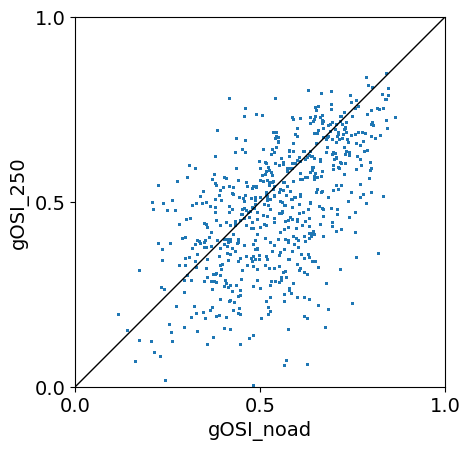

In [ ]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

### filter cell SNR_mod, validate tuning
neuron in model should have diff tuning curves

In [27]:
ncell_keep = 999
iarea = 'LM'
idatesess = 0 # Li, sess=9: not enough cells

# filter_cell = 'vis_pval'
# filter_cell = 'SNR'
# filter_cell = 'SNR_R1_mod'
filter_cell = 'well_fit'
# filter_cell = 'gOSI'

df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=idatesess, 
                    ncell_keep=ncell_keep, 
                    filter_cell=filter_cell)

df_svc.cell_id.nunique()

29

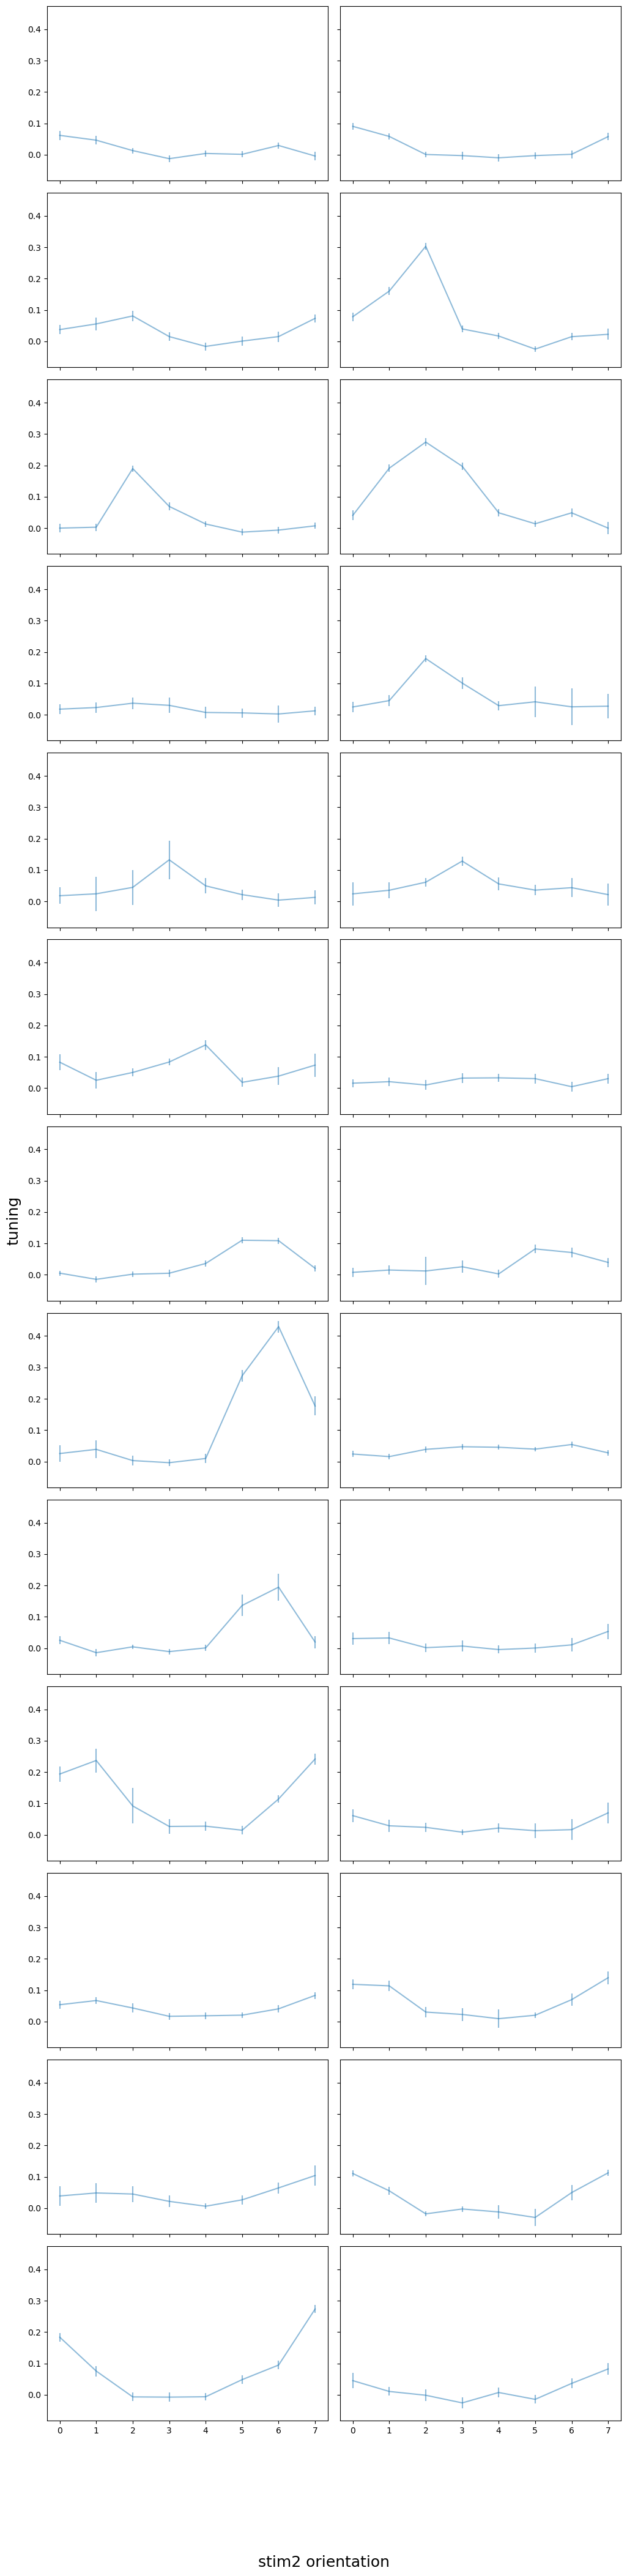

In [26]:
model_cell_resp = df_svc.groupby(['cell_id', 'stim2_id']).dfof.mean().reset_index()
model_cell_sem = df_svc.groupby(['cell_id', 'stim2_id']).dfof.sem().reset_index()

tuning_pop = []
tuning_pop_sem = []
for icell in sorted(df_svc.cell_id.unique()):
    tuning_cell = model_cell_resp[model_cell_resp.cell_id==icell].dfof.tolist()
    tuning_cell_sem = model_cell_sem[model_cell_sem.cell_id==icell].dfof.tolist()
    # tuning_cell = (tuning_cell - np.min(tuning_cell)) / (np.max(tuning_cell) - np.min(tuning_cell)) # min-max normalization
    tuning_pop.append(tuning_cell)
    tuning_pop_sem.append(tuning_cell_sem)

tuning_pop = np.array(tuning_pop) # ncell_keep x nori
tuning_pop_sem = np.array(tuning_pop_sem)
tuning_pop = tuning_pop[np.argsort(np.argmax(tuning_pop, axis=1)), :] # sort cells by tuning argmax
tuning_pop_sem = tuning_pop_sem[np.argsort(np.argmax(tuning_pop, axis=1)), :]

if ncell_keep > 15:
    nrow = 13
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 40), sharex=True, sharey=True)
else:
    nrow = 5
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 20), sharex=True, sharey=True)

for isubplot in np.arange(nrow*ncol): # plot each cell in a subplot
    ax[isubplot//ncol, isubplot%ncol].errorbar(x=np.arange(8), 
                                               y=tuning_pop[isubplot], 
                                               yerr=tuning_pop_sem[isubplot], 
                                               alpha=0.5)
    # ax[isubplot//ncol, isubplot%ncol].text(0.5, 0.9, 
    #             f'cell ' + sorted(df_svc.cell_id.unique())[isubplot].split('_')[2],
    #             horizontalalignment='center',
    #             transform=ax[isubplot//ncol, isubplot%ncol].transAxes,
    #             fontsize=14)
        
fig.text(0.5, -0.05, 'stim2 orientation', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'tuning', va='center', rotation='vertical', fontsize=18)
fig.tight_layout()

dir_fig = os.path.join(dir_repo, r'\results\decoder_grat8\filter cell selection/'.replace('\\', '/'))
# fig.savefig(dir_fig + 'tuning_of_model_cells_SNR_R1_mod.pdf', bbox_inches='tight')

# data cleaning

### filter sess SVM
filter sess by perf at isi=6k, easiest decoding task, val acc > thresh

In [28]:
## for each sess, take easiest task (isi=6k, 0 vs 90, flexible C), record val acc

ncell_keep = 999
C_init = 0.1

# if ncell_keep <= 15:
#     C_init = 0.1
# elif ncell_keep == 999:
#     C_init = 0.05
# C_init = 1 # if without standard scaler z score
# C_init = 1 # RBF kernel SVM, 15 cell
# C_init = 0.1 # decode stim2_dist, 15 cell -> very bad perf


val_acc_history = []
bad_sess_history = []
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

        C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
        niter = 0
        while niter < 4: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
            clf = make_pipeline(StandardScaler(),
                                LinearSVC(tol=1e-5, max_iter=int(1e7), 
                                        penalty='l1', dual='auto', C=C_current)
                                # LinearSVR(epsilon=0, 
                                #     tol=1e-5, max_iter=int(1e7), 
                                #     C=C_current, 
                                #     dual="auto", random_state=0,)
                                )
            # clf = make_pipeline(StandardScaler(),
            #                     SVC(C=C_current, kernel='rbf', gamma='scale', 
            #                         max_iter=int(1e6))
            #                     )
            score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            if (np.mean(score_val['train_score']) <= 0.5) or (np.mean(score_val['test_score']) <= 0.5): # train acc is too low, underfit
                C_current *= 2
                niter += 1
                print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}')
            elif (np.mean(score_val['train_score'])) >= 1: # train acc is too high, overfit
                C_current /= 2
                niter += 1
                print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}')
            else:
                val_acc = np.mean(score_val['test_score'])
                val_acc_history.append(val_acc)
                if val_acc < 0.7: # NOTE: adjust according to hist
                    bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                    bad_sess_history.append(bad_sess)
                break # record res, stop searching for C

            if niter == 4: # too many tries, give up fitting
                print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, C={C_current}')

 33%|███▎      | 2/6 [00:02<00:05,  1.48s/it]

train acc overfit: area=V1, sess=1, isi=isi=6k


 36%|███▋      | 8/22 [00:12<00:21,  1.52s/it]

train acc overfit: area=LM, sess=7, isi=isi=6k


 41%|████      | 9/22 [00:13<00:20,  1.54s/it]

train acc overfit: area=LM, sess=8, isi=isi=6k


 82%|████████▏ | 18/22 [00:27<00:06,  1.54s/it]

train acc overfit: area=LM, sess=17, isi=isi=6k


 20%|██        | 3/15 [00:04<00:16,  1.39s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:06<00:13,  1.37s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:08<00:12,  1.36s/it]

not enough vis cells: area=LI, sess=5


 60%|██████    | 9/15 [00:12<00:08,  1.38s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:13<00:06,  1.37s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:16<00:04,  1.37s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]

not enough vis cells: area=LI, sess=14


(36,
 12,
 ['201209_002',
  '200721_002',
  '200729_003',
  '211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '230307_004',
  '201202_004',
  '210203_003',
  '210203_004',
  '230228_003'])

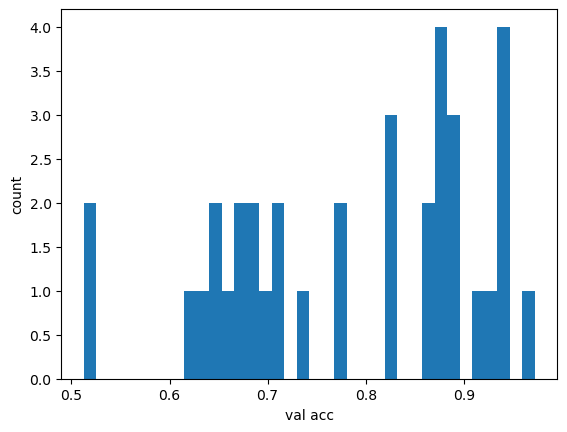

In [29]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

len(val_acc_history), len(bad_sess_history), bad_sess_history
# ['200729_003',
#   '211020_002',
#   '230221_002',
#   '230221_003',
#   '201202_004',
#   '210203_004']

#### filter by auROC (deprecated)
- https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

In [143]:
## for each sess, take easiest task (isi=6k, 0 vs 90, flexible C), record val acc

ncell_keep = 15
if ncell_keep <= 15:
    C_init = 0.1
elif ncell_keep == 999:
    C_init = 0.05
# C_init = 1 # if without standard scaler z score
# C_init = 1 # RBF kernel SVM, 15 cell
# C_init = 0.1 # decode stim2_dist, 15 cell -> very bad perf


val_acc_history = []
bad_sess_history = []
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)
        
        scaler = StandardScaler(with_mean=False, with_std=True)
        X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000) # supervised fit then transform

        C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
        niter = 0
        while niter < 4: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
            # clf = make_pipeline(StandardScaler(),
            #                     LinearSVC(tol=1e-5, max_iter=int(1e7), 
            #                             penalty='l1', dual='auto', C=C_current)
            #                     )
            # clf = make_pipeline(StandardScaler(),
            #                     SVC(C=C_current, kernel='rbf', gamma='scale', 
            #                         max_iter=int(1e6))
            #                     )
            # score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            clf = SVC(kernel='linear', 
                    C=C_current, # penalty has to be L2. NOTE: we no longer use L1 reg
                    probability=True, random_state=42,
                    max_iter=-1, 
                    decision_function_shape='ovo',
                    )
            score_val = cross_validate(clf, X_train_6000, y_train_6000, 
                                    #    cv=LeaveOneOut(), 
                                    cv=5, 
                                    scoring='roc_auc_ovo', # val auROC
                                    return_train_score=True, # train auROC
                                    )
            

            if np.mean(score_val['train_score']) - np.std(score_val['train_score']) <= 0.5: # lower errbar too low, underfit
                C_current *= 2
                niter += 1
                print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}')
            # elif np.mean(score_val['train_score']) >= 1: # upper errbar too high, overfit
            #     C_current /= 2
            #     niter += 1
            #     print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}')
            else:
                val_acc = np.mean(score_val['test_score']) # actually is val auROC, not acc
                val_acc_history.append(val_acc)
                if val_acc < 0.75: # NOTE: adjust according to hist
                    bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                    bad_sess_history.append(bad_sess)
                    print(f'bad val perf: {bad_sess}. area={iarea}, sess={isess}, isi={use_data}, C={C_current}')
                break # record res, stop searching for C

            if niter == 4: # too many tries, give up fitting
                bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                bad_sess_history.append(bad_sess)
                print(f'unable to fit: {bad_sess}. area={iarea}, sess={isess}, isi={use_data}, C={C_current}')

 77%|███████▋  | 17/22 [00:23<00:07,  1.41s/it]

train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
unable to fit: area=LM, sess=16, isi=isi=6k, C=1.6


 13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

train acc underfit: area=LI, sess=1, isi=isi=6k


 20%|██        | 3/15 [00:04<00:16,  1.33s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:07<00:11,  1.31s/it]

not enough vis cells: area=LI, sess=5


 53%|█████▎    | 8/15 [00:10<00:09,  1.33s/it]

train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
unable to fit: area=LI, sess=7, isi=isi=6k, C=1.6


 60%|██████    | 9/15 [00:11<00:07,  1.32s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:13<00:06,  1.31s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:15<00:03,  1.31s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:19<00:00,  1.32s/it]

not enough vis cells: area=LI, sess=14


(34,
 6,
 ['211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '200806_003',
  '210203_004'])

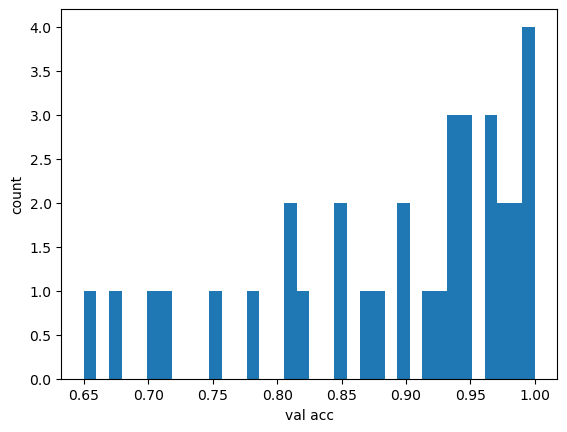

In [145]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

len(val_acc_history), len(bad_sess_history), bad_sess_history
# ['200729_003',
#   '211020_002',
#   '230221_002',
#   '230221_003',
#   '201202_004',
#   '210203_004']

### filter sess rand forest

In [30]:
## for each sess, take easiest task (isi=6k, 0 vs 90), record val acc

ncell_keep = 999
val_acc_history = []
bad_sess_history = []

for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

        clf = make_pipeline(StandardScaler(),
                            RandomForestClassifier(n_estimators=100, # max_depth=10,
                                                   random_state=42,
                                                   bootstrap=True, oob_score=True, 
                                                   n_jobs=-1)
                            )
        clf.fit(X_train_6000, y_train_6000)
        val_acc = clf.named_steps.randomforestclassifier.oob_score_ # out of bag score, basically val acc (data left out in bootstrap / each tree)
        val_acc_history.append(val_acc)
        
        if val_acc < 0.7: # NOTE: adjust according to hist
            bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
            bad_sess_history.append(bad_sess)

 20%|██        | 3/15 [00:04<00:17,  1.42s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:07<00:14,  1.42s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:08<00:12,  1.39s/it]

not enough vis cells: area=LI, sess=5


 60%|██████    | 9/15 [00:12<00:08,  1.42s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:14<00:06,  1.39s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:17<00:04,  1.40s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:21<00:00,  1.43s/it]

not enough vis cells: area=LI, sess=14


(36,
 10,
 ['200729_003',
  '211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '200806_003',
  '201202_004',
  '210203_003',
  '210203_004',
  '230228_003'])

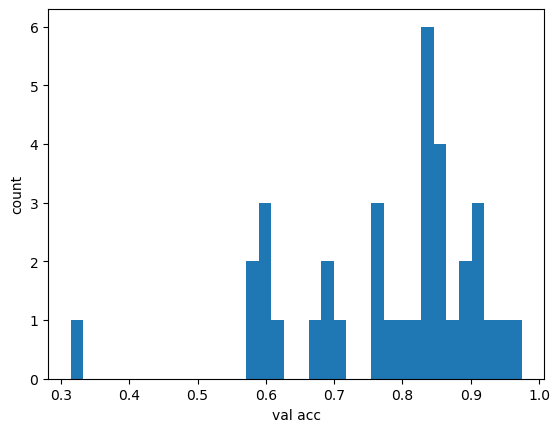

In [31]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

val_acc_history = np.array(val_acc_history)
len(val_acc_history), len(val_acc_history[val_acc_history < 0.7]), bad_sess_history

# SVM cross val search reg
find optimal reg param C

## aware decoder

two separate models for two isi.  
one model: train and test with isi=6k  
another model: train and test with isi=250  

In [35]:
for iarea in ['V1', 'LM', 'LI']:
    print(iarea)
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in tqdm(range(5)): # nsess
        
        ncell_keep = 999 # check how much overfit if keep all cells
        # ncell_keep = 15
        # filter_cell = 'SNR_R1_mod'
        filter_cell = 'well_fit'
        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={idatesess}')
            continue
        tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
        if tmp in bad_sess_history:
            print(f'bad sess due to low val acc on easy task: area={iarea}, sess={idatesess}')
            continue

        tmp = df_svc.stim2_id.unique()
        # tmp = df_svc.stim2_dist_id.unique()
        ref_ori_id = 4 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
        other_ori = sorted(tmp[tmp != ref_ori_id]) # decode ref vs not ref

        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                # df_pair = df_svc[((df_svc.stim2_dist_id == ref_ori_id) | (df_svc.stim2_dist_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                ## split train vs test for each isi
                X_train_250, y_train_250, _, _ = df_to_train_test(df_pair_250, ref_ori_id, train_only=True) # no test data
                X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

                ## standard scaler normalization
                scaler = StandardScaler(with_mean=False, with_std=True)
                X_train_250 = scaler.fit_transform(X_train_250, y=y_train_250)
                X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_ci = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                # C_list = [1e-2 * 10**i for i in range(5)]
                # C_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20] # zoom in around 1
                C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in C_list:
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)
                    #                     # SVC(C=C_val, kernel='rbf', gamma='auto', 
                    #                     #     max_iter=int(1e6))
                                        )
                    # clf = SVC(kernel='linear', 
                    #         C=C_val, # penalty has to be L2. NOTE: we no longer use L1 reg
                    #         probability=True, random_state=42,
                    #         max_iter=-1, 
                    #         decision_function_shape='ovo',
                    #         )
                    
                    if use_data == 'isi=250':
                        score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_250, y_train_250, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    elif use_data == 'isi=6k':
                        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_6000, y_train_6000, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    ## from here on, if using scoring='roc_auc_ovo', then acc_xx is actually auROC_xx
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['train_score'].sum(), nobs=len(score_val['train_score']))
                    acc_train_ci.append((ci_high - ci_low) / 2)
                    # acc_train_ci.append(np.std(score_val['train_score']))
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    acc_val_ci.append((ci_high - ci_low) / 2)
                    # acc_val_ci.append(np.std(score_val['test_score']))
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_ci, fmt='o', capsize=5, capthick=2, label='train', alpha=0.5)
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val', alpha=0.5)
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='gray', alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k', alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs {22.5*ref_ori_id} deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            plt.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results/decoder_grat8/aware decoder/auROC, C param tuning/'.replace('\\', '/'))
            if not os.path.exists(dir_fig): # mkdir if not exist
                os.makedirs(dir_fig)
            fig.savefig(dir_fig + f'aware_decoder_{use_data}_{filter_cell}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)
        
        
            # fix_C = 1
            # acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']

            # plt.errorbar(x=np.arange(len(stim2_ori_list)), 
            #             y=acc_val_C, 
            #             yerr=acc_val_ci_C, 
            #             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
            # plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
            # plt.xlabel('stim2_ori')
            # plt.ylabel(f'acc_val');

            # title_str = f'aware decoder stim2_dist, C={fix_C}, {use_data}, {filter_cell}_{iarea}_{idatesess}'
            # plt.title(title_str);
            # plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')
            # plt.close()

V1


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:14<00:58, 14.55s/it]

isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


 40%|████      | 2/5 [00:30<00:46, 15.34s/it]

isi=250
isi=6k


 60%|██████    | 3/5 [00:45<00:30, 15.43s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [01:00<00:15, 15.18s/it]

isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


100%|██████████| 5/5 [01:17<00:00, 15.51s/it]


LM


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 40%|████      | 2/5 [00:15<00:19,  6.63s/it]

bad sess due to low val acc on easy task: area=LM, sess=1
isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


 60%|██████    | 3/5 [00:32<00:22, 11.32s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [00:46<00:12, 12.44s/it]

isi=250
isi=6k


100%|██████████| 5/5 [00:59<00:00, 11.91s/it]


LI


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


 40%|████      | 2/5 [00:15<00:19,  6.65s/it]

bad sess due to low val acc on easy task: area=LI, sess=1


 60%|██████    | 3/5 [00:16<00:08,  4.22s/it]

not enough vis cells: area=LI, sess=2


 80%|████████  | 4/5 [00:18<00:03,  3.08s/it]

bad sess due to low val acc on easy task: area=LI, sess=3


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]

not enough vis cells: area=LI, sess=4


## xp unaware decoder
train with both, test with either - assume decoder learned from visual xp

In [126]:
for iarea in ['V1', 'LM', 'LI']:
    print(iarea)
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in tqdm(range(5)): # nsess
        
        # ncell_keep = 999 # check how much overfit if keep all cells
        ncell_keep = 15
        filter_cell = 'SNR_R1_mod'
        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={idatesess}')
            continue
        tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
        if tmp in bad_sess_history: # for xp unaware decoder, inherit bad sess from aware decoder
            print(f'bad sess due to low val acc on easy task: area={iarea}, sess={idatesess}')
            continue

        tmp = df_svc.stim2_id.unique()
        ref_ori_id = 4 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
        other_ori = sorted(tmp[tmp != ref_ori_id]) # decode ref vs not ref

        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                X_train, y_train, _, _ = df_to_train_test(df_pair, ref_ori_id, train_only=True)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_ci = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                C_list = [1e-2 * 10**i for i in range(5)]
                # C_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20] # zoom in around 1
                # C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in C_list:
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)
                                        # SVC(C=C_val, kernel='rbf', gamma='auto', 
                                        #     max_iter=int(1e6))
                                        )
                    
                    score_val = cross_validate(clf, X_train, y_train, cv=LeaveOneOut(), return_train_score=True)

                    ## LeaveOneOut() keeps the order of train data. inherit ISI info from df_to_train_test(df_pair...) & separately calculate acc for each ISI
                    isi_arr = df_pair.groupby('trial_id').isi.first().values # same as how we get label_arr (y_train) in df_to_train_test
                    if use_data == 'isi=250':
                        score_val['train_score'] = score_val['train_score'][isi_arr==250]
                        score_val['test_score'] = score_val['test_score'][isi_arr==250]
                    elif use_data == 'isi=6k':
                        score_val['train_score'] = score_val['train_score'][isi_arr==6000]
                        score_val['test_score'] = score_val['test_score'][isi_arr==6000]

                    
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['train_score'].sum(), nobs=len(score_val['train_score']))
                    acc_train_ci.append((ci_high - ci_low) / 2)
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    acc_val_ci.append((ci_high - ci_low) / 2)
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_ci, fmt='o', capsize=5, capthick=2, label='train', alpha=0.5)
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val', alpha=0.5)
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='gray', alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k', alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs {22.5*ref_ori_id} deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            fig.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results/decoder_grat8/xp unaware decoder/init, C param tuning/'.replace('\\', '/'))
            if not os.path.exists(dir_fig): # mkdir if not exist
                os.makedirs(dir_fig)
            fig.savefig(dir_fig + f'xp_unaware_decoder_{use_data}_{filter_cell}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)
        
        
            # fix_C = 1
            # acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']

            # plt.errorbar(x=np.arange(len(stim2_ori_list)), 
            #             y=acc_val_C, 
            #             yerr=acc_val_ci_C, 
            #             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
            # plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
            # plt.xlabel('stim2_ori')
            # plt.ylabel(f'acc_val');

            # title_str = f'aware decoder stim2_dist, C={fix_C}, {use_data}, {filter_cell}_{iarea}_{idatesess}'
            # plt.title(title_str);
            # plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')
            # plt.close()

V1


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:26<01:44, 26.11s/it]

isi=250
isi=6k


 40%|████      | 2/5 [01:01<01:34, 31.47s/it]

isi=250
isi=6k


 60%|██████    | 3/5 [01:20<00:51, 25.93s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [01:56<00:29, 29.95s/it]

isi=250
isi=6k


100%|██████████| 5/5 [02:15<00:00, 27.19s/it]


LM


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 40%|████      | 2/5 [00:19<00:25,  8.34s/it]

bad sess due to low val acc on easy task: area=LM, sess=1
isi=250
isi=6k


 60%|██████    | 3/5 [00:38<00:26, 13.33s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [01:01<00:17, 17.15s/it]

isi=250
isi=6k


100%|██████████| 5/5 [01:26<00:00, 17.24s/it]


LI


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:56<03:47, 56.95s/it]

isi=250
isi=6k


 60%|██████    | 3/5 [01:15<00:37, 18.91s/it]

not enough vis cells: area=LI, sess=2


 80%|████████  | 4/5 [01:17<00:11, 11.97s/it]

bad sess due to low val acc on easy task: area=LI, sess=3


100%|██████████| 5/5 [01:18<00:00, 15.67s/it]

not enough vis cells: area=LI, sess=4


## naive unaware decoder (to clean)
train with 6k, test with either - more directly related to decorr, give lower bound of decoding acc

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


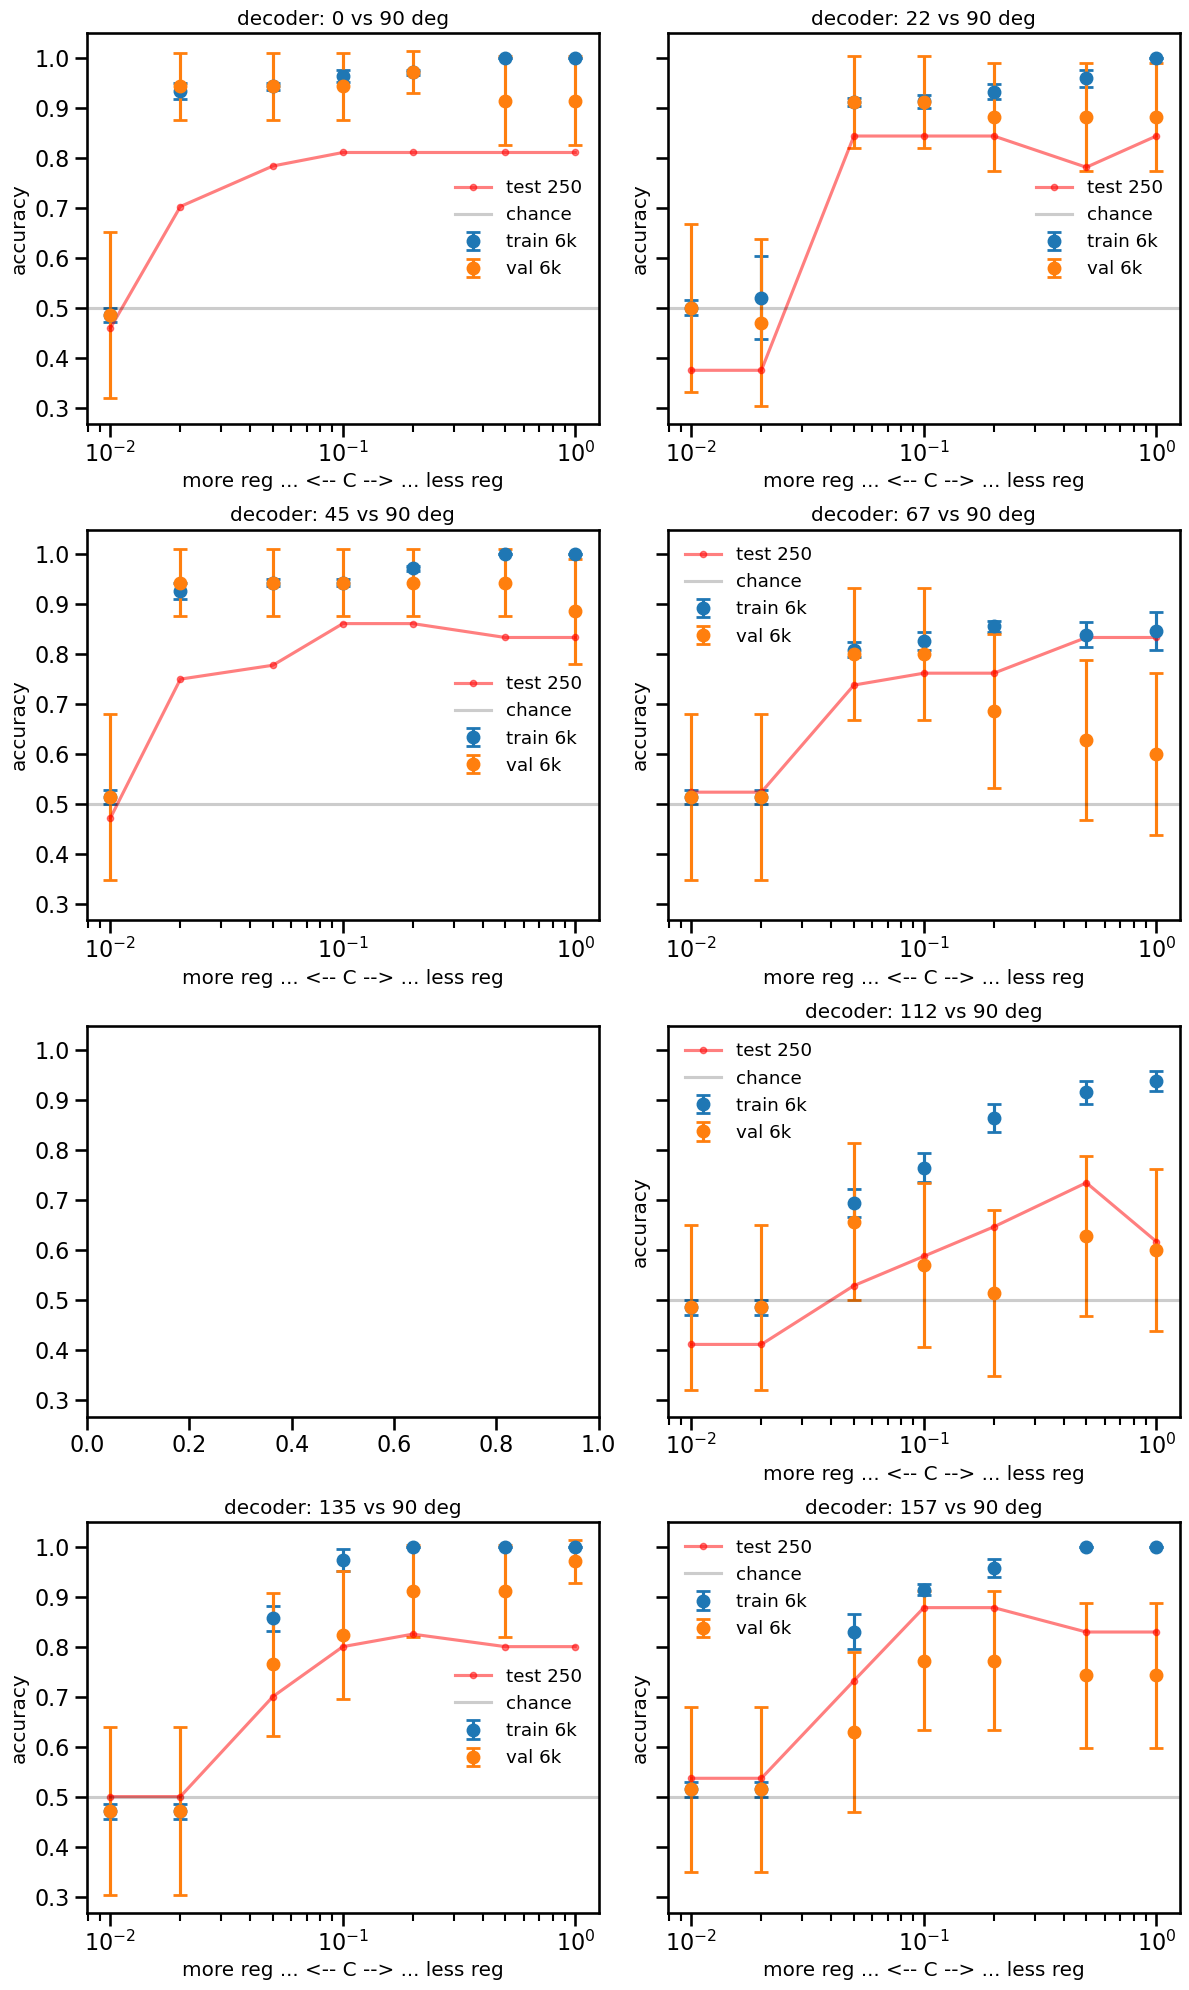

In [ ]:
## find optimal reg param C. 

nrow = 4
ncol = 2
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
acc_test_iori = []

for iori in tqdm(other_ori):
    
    ## get data for each pair of ori (another vs 90 deg)
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, y_train_250, X_test_250, y_test_250 = df_to_train_test(df_pair_250, train_only=True) # no test data
    X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, train_only=True)

    # ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    # X_train = np.vstack((X_train_250, X_train_6000))
    # y_train = np.hstack((y_train_250, y_train_6000))
    # X_test = np.vstack((X_test_250, X_test_6000))
    # y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    # use_data = 'isi=250' # train with unadapted, test with adapted
    # use_data = 'isi=6k' # train with unadapted, test with unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))

        ## train and val with isi 6k. val is considered as test
        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)

        ## test with isi 250. train_250 is considered as test (bc model is trained with isi 6k)
        clf.fit(X_train_6000, y_train_6000)
        score_test = clf.score(X_train_250, y_train_250) # test data has only 1 trial. use train as test for isi 250
        acc_test.append(score_test)
        
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
    acc_test_iori.append(acc_test)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train 6k')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val 6k')
    ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test 250')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_train_val_6k_test_250.pdf', bbox_inches='tight')

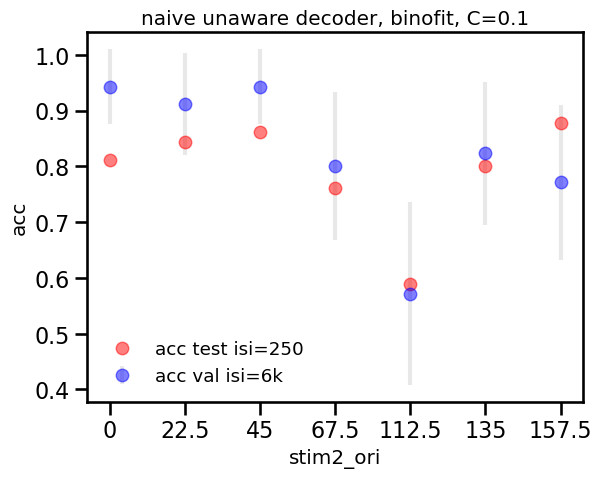

In [ ]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_test_C = np.array(acc_test_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             label='acc val isi=6k',
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);
plt.plot(acc_test_C, 'o', color='r', alpha=0.5, label='acc test isi=250')

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc');
plt.legend(frameon=False, loc='lower left')

title_str = f'naive unaware decoder, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

# decoder across area
area subplot, isi color, date_sess concat acc errorbar  
fixed C

## aware decoder

In [201]:
decoder_type = 'linear SVM'

tmp = df_tidy.stim2_id.unique()
ref_ori_id = 4 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
other_ori = sorted(tmp[tmp != ref_ori_id]) # decode ref vs not ref

ncell_keep = 15
if ncell_keep <= 15:
    C_init = 0.1
elif ncell_keep == 999:
    C_init = 0.05
# C_init = 1 # if without standard scaler z score, or RBF kernel SVM, 15 cell


if decoder_type == 'random forest':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    ])
elif decoder_type == 'linear SVM':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    'true_pos_train', 'n_sample_train', 'train_acc', # three var for train acc
                                    'C', 'bad_fit'])
    
for iarea in ['V1', 'LM', 'LI']:

    for use_data in ['isi=250', 'isi=6k']:
        nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                            & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                        .groupby(['date', 'sess'])
                        .first().__len__())
        
        for isess in tqdm(range(nsess_iarea)):
            df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                                ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
            if df_svc.cell_id.nunique() < 5:
                print(f'not enough vis cells: area={iarea}, sess={isess}')
                continue
            tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
            if tmp in bad_sess_history:
                print(f'bad sess due to low val acc on easy task: area={iarea}, sess={isess}')
                continue

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                X_train_250, y_train_250, _, _ = df_to_train_test(df_pair_250, ref_ori_id, train_only=True) # no test data
                X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

                ## standard scaler normalization
                scaler = StandardScaler(with_mean=False, with_std=True)
                X_train_250 = scaler.fit_transform(X_train_250, y=y_train_250)
                X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000)

                if decoder_type == 'random forest':
                    clf = make_pipeline(StandardScaler(),
                                        RandomForestClassifier(n_estimators=100,
                                                            random_state=42,
                                                            bootstrap=True, oob_score=True, 
                                                            n_jobs=-1)
                                        )
                    
                    if use_data == 'isi=250':
                        clf.fit(X_train_250, y_train_250)
                        n_sample = len(y_train_250)
                    elif use_data == 'isi=6k':
                        clf.fit(X_train_6000, y_train_6000)
                        n_sample = len(y_train_6000)

                    val_acc = clf.named_steps.randomforestclassifier.oob_score_
                    true_pos = val_acc * n_sample
                    df_newline = pd.DataFrame({'area': iarea, 'isi': use_data, 'sess': isess, 'ori': iori,
                                                'true_pos': true_pos, 'n_sample': n_sample, 
                                                'val_acc': val_acc
                                                }, 
                                                columns=df_perf.columns, 
                                                index=[0])
                    df_perf = pd.concat([df_newline, df_perf], ignore_index=True)


                elif decoder_type == 'linear SVM':
                    C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
                    niter = 0
                    max_iter = 4
                    while niter < max_iter: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
                        # clf = make_pipeline(StandardScaler(),
                        #                     LinearSVC(tol=1e-5, max_iter=int(1e7), 
                        #                             penalty='l1', dual='auto', C=C_current))
                        # clf = SVC(kernel='linear', 
                        #     C=C_val, # penalty has to be L2. NOTE: this no longer use L1 reg
                        #     probability=True, random_state=42,
                        #     max_iter=-1, 
                        #     decision_function_shape='ovo',
                        #     )
                        clf = LinearSVC(max_iter=int(1e7), 
                                        penalty='l1', dual='auto', C=C_current)
                        nfold = 5

                        if use_data == 'isi=250':
                            # score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                            X_train = X_train_250.copy()
                            y_train = y_train_250.copy()
                        elif use_data == 'isi=6k':
                            # score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                            X_train = X_train_6000.copy()
                            y_train = y_train_6000.copy()
                        score_val = cross_validate(clf, X_train, y_train, 
                                        #    cv=LeaveOneOut(), 
                                        cv=nfold, 
                                        scoring='roc_auc_ovo', # val auROC
                                        return_train_score=True, # train auROC
                                        )

                        ## from here on, if using scoring='roc_auc_ovo', then acc_xx is actually auROC_xx
                        if np.mean(score_val['train_score']) <= 0.5: # lower err of train acc is too low, underfit
                            C_current *= 2
                            niter += 1
                            print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        elif np.min(score_val['train_score']) >= 1: # NOTE: had to relax from mean to min, somehow very easy to get train auROC=1
                            C_current /= 2
                            niter += 1
                            print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        else:
                            break # record res, stop searching for C

                    ## outside of while loop, record res
                    n_sample = len(y_train) / nfold
                    true_pos = score_val['test_score'].mean() * n_sample
                    n_sample_train = len(y_train) - n_sample
                    true_pos_train = score_val['train_score'].mean() * n_sample_train
                    # true_pos = score_val['test_score'].sum()
                    # n_sample = len(score_val['test_score'])
                    # n_sample_train = n_sample - 1 # leave one out (LOO)
                    # true_pos_train = score_val['train_score'].mean() * n_sample_train # mean train acc across LOO attempts

                    bad_fit = False
                    if niter == max_iter: # too many tries, this is a bad fit
                        print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}, C={C_current}')
                        bad_fit = True

                    df_newline = pd.DataFrame({'area': iarea, 'isi': use_data, 'sess': isess, 'ori': iori,
                                                'true_pos': true_pos, 'n_sample': n_sample, 
                                                'val_acc': np.mean(score_val['test_score']), 
                                                'true_pos_train': true_pos_train, 'n_sample_train': n_sample_train, 
                                                'train_acc': np.mean(score_val['train_score']),
                                                'C': C_current, 'bad_fit': bad_fit}, 
                                                columns=df_perf.columns, 
                                                index=[0])
                    df_perf = pd.concat([df_newline, df_perf], ignore_index=True)

## 3 min to run linear SVM,  min to run random forest

  0%|          | 0/6 [00:00<?, ?it/s]c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
   

KeyboardInterrupt: 

In [202]:
## try switch back to L1 linear SVC from L2 SVC
# https://stackoverflow.com/questions/47312432/attributeerrorlinearsvc-object-has-no-attribute-predict-proba

clf.fit(X_train, y_train)

res = clf._predict_proba_lr(X_train, y_train)

TypeError: LinearClassifierMixin._predict_proba_lr() takes 2 positional arguments but 3 were given

In [194]:
df_perf['ori_dist_id'] = df_perf.ori.apply(lambda x: stim2_dict[x])
# df_perf.ori_dist_id.value_counts()
df_perf

,area,isi,sess,ori,true_pos,n_sample,val_acc,true_pos_train,n_sample_train,train_acc,C,bad_fit,ori_dist_id
0,LI,isi=6k,13,7,5.180000,7.4,0.700000,23.063979,29.6,0.779188,0.100000,False,1
1,LI,isi=6k,13,6,3.810000,7.2,0.529167,22.132898,28.8,0.768503,0.100000,False,2
2,LI,isi=6k,13,5,3.540000,7.2,0.491667,27.943837,28.8,0.970272,0.100000,False,3
3,LI,isi=6k,13,3,4.050000,7.2,0.562500,21.835102,28.8,0.758163,0.100000,False,3
4,LI,isi=6k,13,2,3.145000,7.4,0.425000,22.489892,29.6,0.759794,0.100000,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,V1,isi=250,0,5,5.483333,7.0,0.783333,28.000000,28.0,1.000000,0.000098,True,3
416,V1,isi=250,0,3,5.740500,8.6,0.667500,33.705336,34.4,0.979806,0.100000,False,3
417,V1,isi=250,0,2,6.629167,7.4,0.895833,29.600000,29.6,1.000000,0.000098,True,2
418,V1,isi=250,0,1,6.600000,6.6,1.000000,26.400000,26.4,1.000000,0.000098,True,1


### reg param C history

In [195]:
df_perf.bad_fit.value_counts()

bad_fit
False    252
True     168
Name: count, dtype: int64

[127, 252, 41]

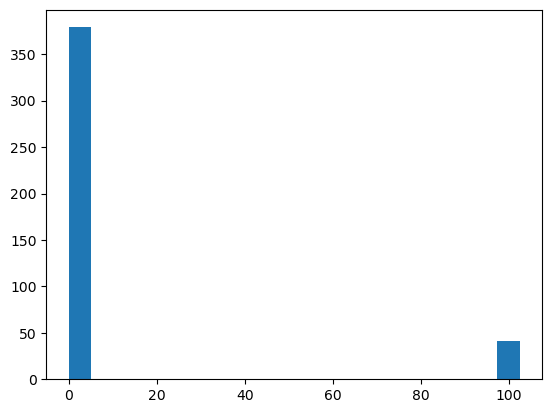

In [196]:
C_history = list(df_perf.C.values)
plt.hist(C_history, bins=20);

# count unique C values
unique_C = np.unique(C_history)
count_C = []
for iC in unique_C:
    count_C.append(C_history.count(iC))

count_C

## xp unaware decoder

In [127]:
decoder_type = 'random forest'

ref_ori_id = 4 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
tmp = df_tidy.stim2_id.unique()
other_ori = sorted(tmp[tmp != ref_ori_id]) # decode ref vs not ref

if decoder_type == 'random forest':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    ])
elif decoder_type == 'linear SVM':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    'true_pos_train', 'n_sample_train', 'train_acc', # three var for train acc
                                    'C', 'bad_fit'])

for iarea in ['V1', 'LM', 'LI']:
    C_init = 0.1
    if iarea == 'LI':
        C_init = 1 # less reg for LI bc fewer cells

    for use_data in ['isi=250', 'isi=6k']:
        nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                            & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                        .groupby(['date', 'sess'])
                        .first().__len__())
        
        for isess in tqdm(range(nsess_iarea)):
            df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                                ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
            if df_svc.cell_id.nunique() < 5:
                print(f'not enough vis cells: area={iarea}, sess={isess}')
                continue
            tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
            if tmp in bad_sess_history: # for xp unaware decoder, inherit bad sess from aware decoder
                print(f'bad sess due to low val acc on easy task: area={iarea}, sess={isess}')
                continue

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                X_train, y_train, _, _ = df_to_train_test(df_pair, ref_ori_id, train_only=True)

                if decoder_type == 'random forest':
                    clf = make_pipeline(StandardScaler(),
                            RandomForestClassifier(n_estimators=100,
                                                   random_state=42,
                                                   bootstrap=True, oob_score=True, 
                                                   n_jobs=-1)
                            )
                    clf.fit(X_train, y_train)
                    val_acc = clf.named_steps.randomforestclassifier.oob_score_ # out of bag score, basically val acc (data left out in bootstrap / each tree)
                    # val_acc_history.append(val_acc)
                    # TODO: rand forest cannot extract isi info! can only do aware decoder for now

                elif decoder_type == 'linear SVM':
                    C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
                    niter = 0
                    while niter < 4: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
                        clf = make_pipeline(StandardScaler(),
                                            LinearSVC(tol=1e-5, max_iter=int(1e7), 
                                                    penalty='l1', dual='auto', C=C_current))

                        score_val = cross_validate(clf, X_train, y_train, cv=LeaveOneOut(), return_train_score=True)

                        ## LeaveOneOut() keeps the order of train data. inherit ISI info from df_to_train_test(df_pair...) & separately calculate acc for each ISI
                        isi_arr = df_pair.groupby('trial_id').isi.first().values # same as how we get label_arr (y_train) in df_to_train_test
                        if use_data == 'isi=250':
                            score_val['train_score'] = score_val['train_score'][isi_arr==250]
                            score_val['test_score'] = score_val['test_score'][isi_arr==250]
                        elif use_data == 'isi=6k':
                            score_val['train_score'] = score_val['train_score'][isi_arr==6000]
                            score_val['test_score'] = score_val['test_score'][isi_arr==6000]

                        if np.mean(score_val['train_score']) - np.std(score_val['train_score']) <= 0.5: # lower err of train acc is too low, underfit
                            C_current *= 2
                            niter += 1
                            print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        elif np.mean(score_val['train_score']) >= 1: # train acc is too high, overfit. dont consider err
                            C_current /= 2
                            niter += 1
                            print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        else:
                            break # record res, stop searching for C

                    ## outside of while loop, record res
                    true_pos = score_val['test_score'].sum()
                    n_sample = len(score_val['test_score'])
                    n_sample_train = n_sample - 1 # leave one out (LOO), note this is train set size for each isi (not the whole train set, which the model is trained on)
                    true_pos_train = score_val['train_score'].mean() * n_sample_train # avg train acc across LOO attempts
                    # true_pos_ori[iori] += true_pos
                    # n_sample_ori[iori] += n_sample

                    bad_fit = False
                    if niter == 4: # too many tries, this is a bad fit
                        print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}, C={C_current}')
                        bad_fit = True

                    df_newline = pd.DataFrame({'area': iarea, 'isi': use_data, 'sess': isess, 'ori': iori,
                                                'true_pos': true_pos, 'n_sample': n_sample, 
                                                'val_acc': np.mean(score_val['test_score']), 
                                                'true_pos_train': true_pos_train, 'n_sample_train': n_sample_train, 
                                                'train_acc': np.mean(score_val['train_score']),
                                                'C': C_current, 'bad_fit': bad_fit}, 
                                                columns=df_perf.columns, 
                                                index=[0])
                    df_perf = pd.concat([df_newline, df_perf], ignore_index=True)
                
## 3 min to run

  9%|▉         | 2/22 [00:03<00:37,  1.87s/it]

bad sess due to low val acc on easy task: area=LM, sess=1


 55%|█████▍    | 12/22 [00:28<00:21,  2.17s/it]

bad sess due to low val acc on easy task: area=LM, sess=11


 73%|███████▎  | 16/22 [00:37<00:12,  2.10s/it]

bad sess due to low val acc on easy task: area=LM, sess=15


 77%|███████▋  | 17/22 [00:38<00:09,  1.87s/it]

bad sess due to low val acc on easy task: area=LM, sess=16


  9%|▉         | 2/22 [00:03<00:37,  1.86s/it]

bad sess due to low val acc on easy task: area=LM, sess=1


 55%|█████▍    | 12/22 [00:28<00:21,  2.16s/it]

bad sess due to low val acc on easy task: area=LM, sess=11


 73%|███████▎  | 16/22 [00:37<00:12,  2.09s/it]

bad sess due to low val acc on easy task: area=LM, sess=15


 77%|███████▋  | 17/22 [00:38<00:09,  1.86s/it]

bad sess due to low val acc on easy task: area=LM, sess=16


 20%|██        | 3/15 [00:06<00:23,  1.97s/it]

not enough vis cells: area=LI, sess=2


 27%|██▋       | 4/15 [00:07<00:18,  1.70s/it]

bad sess due to low val acc on easy task: area=LI, sess=3


 33%|███▎      | 5/15 [00:08<00:15,  1.55s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:10<00:13,  1.47s/it]

not enough vis cells: area=LI, sess=5


 53%|█████▎    | 8/15 [00:14<00:11,  1.64s/it]

bad sess due to low val acc on easy task: area=LI, sess=7


 60%|██████    | 9/15 [00:15<00:09,  1.53s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:16<00:07,  1.45s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:20<00:04,  1.65s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


not enough vis cells: area=LI, sess=14


 20%|██        | 3/15 [00:06<00:23,  1.98s/it]

not enough vis cells: area=LI, sess=2


 27%|██▋       | 4/15 [00:07<00:18,  1.70s/it]

bad sess due to low val acc on easy task: area=LI, sess=3


 33%|███▎      | 5/15 [00:08<00:15,  1.55s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:10<00:13,  1.47s/it]

not enough vis cells: area=LI, sess=5


 53%|█████▎    | 8/15 [00:14<00:11,  1.64s/it]

bad sess due to low val acc on easy task: area=LI, sess=7


 60%|██████    | 9/15 [00:15<00:09,  1.53s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:16<00:07,  1.44s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:20<00:04,  1.65s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:27<00:00,  1.82s/it]

not enough vis cells: area=LI, sess=14


In [128]:
df_perf['ori_dist_id'] = df_perf.ori.apply(lambda x: stim2_dict[x])
df_perf

,area,isi,sess,ori,true_pos,n_sample,val_acc,true_pos_train,n_sample_train,train_acc,C,bad_fit,ori_dist_id
0,LI,isi=6k,13,7,28.0,37,0.756757,32.036036,36,0.889890,1.0,False,1
1,LI,isi=6k,13,6,25.0,36,0.694444,27.855297,35,0.795866,1.0,False,2
2,LI,isi=6k,13,5,23.0,36,0.638889,26.361750,35,0.753193,1.0,False,3
3,LI,isi=6k,13,3,20.0,36,0.555556,23.942436,35,0.684070,1.0,False,3
4,LI,isi=6k,13,2,21.0,37,0.567568,26.525676,36,0.736824,1.0,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,V1,isi=250,0,5,21.0,35,0.600000,27.505306,34,0.808980,0.1,False,3
416,V1,isi=250,0,3,32.0,43,0.744186,34.273703,42,0.816041,0.1,False,3
417,V1,isi=250,0,2,33.0,37,0.891892,34.081081,36,0.946697,0.1,False,2
418,V1,isi=250,0,1,31.0,33,0.939394,30.118498,32,0.941203,0.1,False,1


### reg param C history

[336, 84]

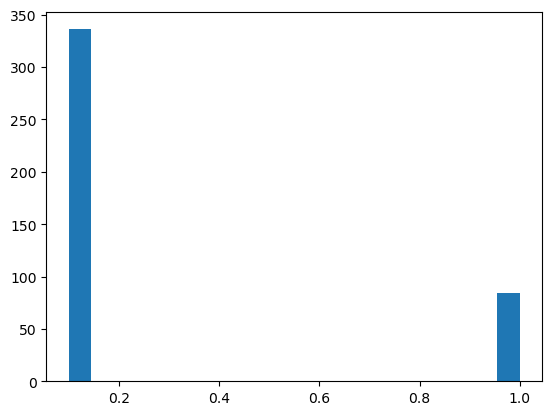

In [129]:
C_history = list(df_perf.C.values)
plt.hist(C_history, bins=20);

# count unique C values
unique_C = np.unique(C_history)
count_C = []
for iC in unique_C:
    count_C.append(C_history.count(iC))

count_C

# decoder perf across area & isi

In [198]:
df_perf_copy = df_perf.copy()
df_perf = df_perf[df_perf.bad_fit == False]

# df_perf = df_perf_copy.copy()

## errorbar as binomial CI

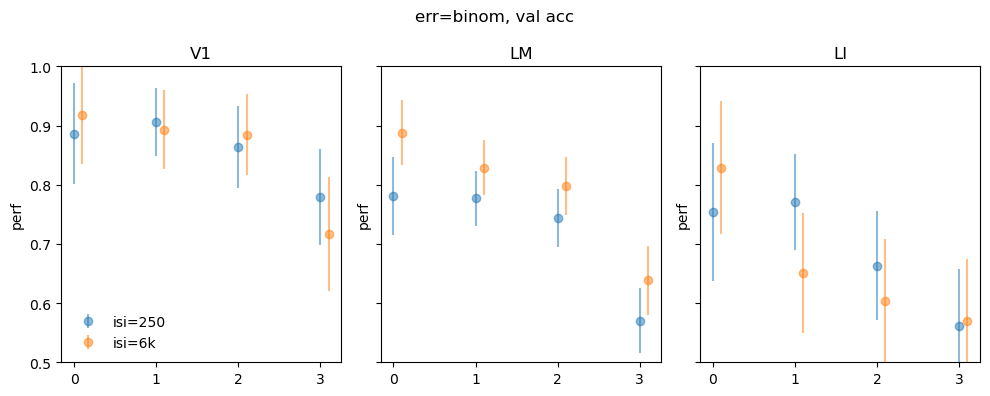

In [165]:
plot_perf = 'val'

if plot_perf == 'val':
    tmp = df_perf.groupby(['area', 'isi', 'ori_dist_id'])[['true_pos', 'n_sample']].sum().reset_index()
    tmp['acc'] = tmp.true_pos / tmp.n_sample
    tmp['ci'] = tmp.apply(lambda x: proportion_confint(count=x.true_pos, nobs=x.n_sample), axis=1)
    tmp['err'] = tmp.apply(lambda x: (x.ci[1] - x.ci[0]) / 2, axis=1)

elif plot_perf == 'train':
    tmp = df_perf.groupby(['area', 'isi', 'ori_dist_id'])[['true_pos_train', 'n_sample_train']].sum().reset_index()
    tmp['acc'] = tmp.true_pos_train / tmp.n_sample_train
    tmp['ci'] = tmp.apply(lambda x: proportion_confint(count=x.true_pos_train, nobs=x.n_sample_train), axis=1)
    tmp['err'] = tmp.apply(lambda x: (x.ci[1] - x.ci[0]) / 2, axis=1)


fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for (i, iarea) in enumerate(['V1', 'LM', 'LI']):
    for (j, iisi) in enumerate(['isi=250', 'isi=6k']):
        
        tmp1 = tmp[(tmp.area == iarea) & (tmp.isi == iisi)].acc.values
        tmp2 = tmp[(tmp.area == iarea) & (tmp.isi == iisi)].err.values
        
        ax[i].errorbar(x=np.arange(len(tmp1)) + j*0.1, 
                    y=tmp1, 
                    yerr=tmp2, 
                    label=iisi, fmt='o', alpha=0.5);

    ax[i].set_ylim(0.5, 1);
    ax[i].set_xticks(np.arange(len(tmp1)));
    # ax[i].set_xticklabels(['90', '67.5', '45', '22.5']);
    # ax[i].set_xlabel('distance from ref ori (deg)')
    ax[i].set_ylabel('perf')
    ax[0].legend(frameon=False, loc='lower left');
    ax[i].set_title(iarea);
    
plt.suptitle(f'err=binom, {plot_perf} acc')
plt.tight_layout();
dir_fig = os.path.join(dir_repo, r'results\decoder_grat8\aware decoder/'.replace('\\', '/'))
# fig.savefig(dir_fig + '.pdf', bbox_inches='tight')

## errorbar as sem
error bar: not accumulated pos vs total, but median & sem acc across sets?

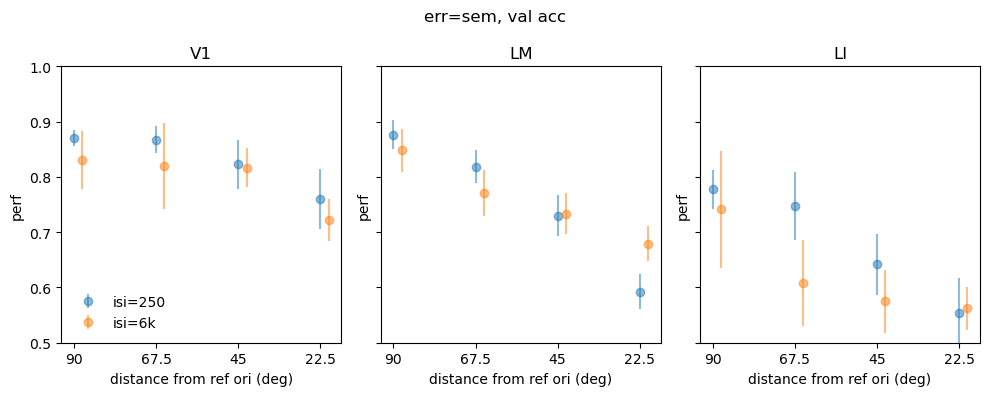

In [199]:
## folded version: pair up by ori_dist from ref or from adapter (they are the same pairing)

plot_perf = 'val'

if plot_perf == 'val':
    sets_agg = df_perf.groupby(['area', 'isi', 'ori_dist_id']).val_acc.median().to_frame().reset_index()
    sets_err = df_perf.groupby(['area', 'isi', 'ori_dist_id']).val_acc.sem().to_frame().reset_index()

elif plot_perf == 'train':
    sets_agg = df_perf.groupby(['area', 'isi', 'ori_dist_id']).train_acc.median().to_frame().reset_index()
    sets_err = df_perf.groupby(['area', 'isi', 'ori_dist_id']).train_acc.sem().to_frame().reset_index()



# warnings.filterwarnings('ignore') # suppress RuntimeWarning: invalid value encountered in true_divide
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

for (i, iarea) in enumerate(['V1', 'LM', 'LI']):
    for (j, iisi) in enumerate(['isi=250', 'isi=6k']):
        
        if plot_perf == 'val':
            tmp1 = sets_agg[(sets_agg.area == iarea) & (sets_agg.isi == iisi)].val_acc.values
            tmp2 = sets_err[(sets_err.area == iarea) & (sets_err.isi == iisi)].val_acc.values
        elif plot_perf == 'train':
            tmp1 = sets_agg[(sets_agg.area == iarea) & (sets_agg.isi == iisi)].train_acc.values
            tmp2 = sets_err[(sets_err.area == iarea) & (sets_err.isi == iisi)].train_acc.values
        
        ax[i].errorbar(x=np.arange(len(tmp1)) + j*0.1, 
                    y=tmp1, 
                    yerr=tmp2, 
                    label=iisi, 
                    fmt='o', alpha=0.5);

    ax[i].set_ylim(0.5, 1);
    ax[i].set_xticks(np.arange(len(tmp1)));
    ax[i].set_xticklabels(['90', '67.5', '45', '22.5']);
    ax[i].set_xlabel('distance from ref ori (deg)')
    ax[i].set_ylabel('perf')
    ax[0].legend(
        # ['isi=250', 'isi=6k'], 
        frameon=False, loc='lower left');
    ax[i].set_title(iarea);
    
plt.suptitle(f'err=sem, {plot_perf} acc')
plt.tight_layout();
dir_fig = os.path.join(dir_repo, r'results\decoder_grat8\aware decoder/'.replace('\\', '/'))
# fig.savefig(dir_fig + '.pdf', bbox_inches='tight')

# multiclass SVR

In [309]:
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=999, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = None
        df_pair = df_svc
        # df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        # X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)
        # X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id=None, train_only=True, multiclass=True)
        X_train_6000, y_train_6000, X_test_6000, y_test_6000 = df_to_train_test(df_pair_6000, ref_ori_id=None, train_only=False, multiclass=True)

        break
    break

  0%|          | 0/6 [00:01<?, ?it/s]


R^2=0.98
R^2=0.32


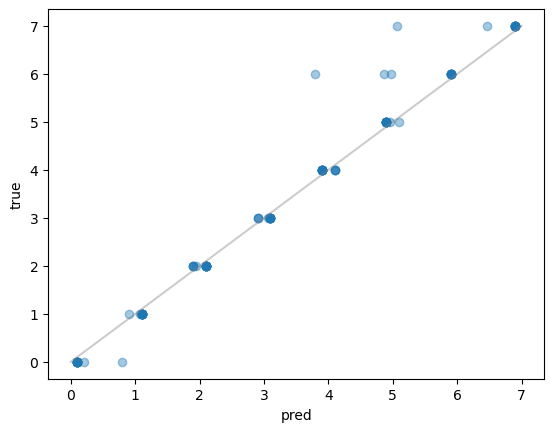

In [326]:
# from sklearn.svm import LinearSVR
# regr = make_pipeline(StandardScaler(),
#                      LinearSVR(epsilon=0, 
#                                tol=1e-5, max_iter=int(1e7), 
#                                C=.1, 
#                                dual="auto", random_state=0,))

from sklearn.svm import SVR
regr = make_pipeline(StandardScaler(),
                     SVR(kernel='rbf', gamma='scale', tol=1e-7, 
                               C=7, epsilon=0.1, max_iter=-1))
regr.fit(X_train_6000, y_train_6000)

R_squared_train = regr.score(X_train_6000, y_train_6000)
print(f'R^2={R_squared_train:.2f}')
R_squared_test = regr.score(X_test_6000, y_test_6000)
print(f'R^2={R_squared_test:.2f}')

plt.scatter(regr.predict(X_train_6000), y_train_6000, alpha=0.4);
# plt.scatter(regr.predict(X_test_6000), y_test_6000, alpha=0.4);
# df_regr = pd.DataFrame({'pred': regr.predict(X_test_6000), 'true': y_test_6000})
# pred_agg = df_regr.groupby('true').pred.mean()
# print(pred_agg)
# plt.scatter(pred_agg, df_regr.true.unique(), alpha=0.4);
plt.plot([0, 7], [0, 7], 'gray', alpha=0.4);
plt.xlabel('pred')
plt.ylabel('true');

# pop vec decoder

In [331]:
df_tidy_ori_pref = pd.read_csv(os.path.join(dir_data, 'df tidy for plots', 'df_tidy_tuning_bias_diff.csv'), index_col=0)
df_tidy_ori_pref = df_tidy_ori_pref[[
    'dfof', 'cell_id', 'trial_id', 'resp_id', 'isi', 'stim2_id', 
    'filter_cell_vis', 'filter_cell_well_fit', 
    'ori_pref_noad', 'ori_pref_ad_750', 'ori_pref_ad_250', 
    'filter_cell_well_fit_ad_250', 'filter_cell_well_fit_ad_750', 
    'area', 'mouse', 'date', 'sess',]]
df_tidy_ori_pref

,dfof,cell_id,trial_id,resp_id,isi,stim2_id,filter_cell_vis,filter_cell_well_fit,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,area,mouse,date,sess
0,-0.003253,200720_003_0,0,R1,750,5,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
1,0.088726,200720_003_0,1,R1,250,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
2,-0.010485,200720_003_0,2,R1,250,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
3,-0.050493,200720_003_0,3,R1,750,3,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
4,0.052611,200720_003_0,5,R1,750,0,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566530,0.056616,230323_003_64,496,R2,6000,5,False,0.0,15.044770,28.692230,111.688536,False,False,LI,1374,230323,3
2566531,0.077247,230323_003_64,497,R2,6000,6,False,0.0,15.044770,28.692230,111.688536,False,False,LI,1374,230323,3
2566532,0.026982,230323_003_64,498,R2,250,6,False,0.0,15.044770,28.692230,111.688536,False,False,LI,1374,230323,3
2566533,-0.069060,230323_003_64,499,R2,6000,7,False,0.0,15.044770,28.692230,111.688536,False,False,LI,1374,230323,3


## ori max 

In [413]:
df_tidy_ori_max = pd.read_csv(os.path.join(dir_data, 'df tidy for plots', 'df_tuning_grat8ori.csv'))
df_tidy_ori_max

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250,gOSI_noad,gOSI_250
0,1.171922,201209_002_88,R1,250,3,V1,True,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0.876308,0.682645
1,0.428161,201209_002_88,R1,250,4,V1,True,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0.876308,0.682645
2,0.609422,201209_002_88,R1,250,1,V1,True,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0.876308,0.682645
3,1.258853,201209_002_88,R1,250,0,V1,True,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0.876308,0.682645
4,1.807948,201209_002_88,R1,250,6,V1,True,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0.876308,0.682645
...,...,...,...,...,...,...,...,...,...,...,...
792479,0.110550,200806_003_45,R2,250,6,LI,True,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0.010661,0.140247
792480,0.107516,200806_003_45,R2,250,5,LI,True,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0.010661,0.140247
792481,0.058562,200806_003_45,R2,6000,1,LI,True,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0.010661,0.140247
792482,0.065887,200806_003_45,R2,6000,5,LI,True,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0.010661,0.140247


In [414]:
df_tidy_ori_max = df_tidy_ori_max[['cell_id', 'tuning_noad', 'tuning_250']]
df_tidy_ori_max['ori_max_noad'] = df_tidy_ori_max.tuning_noad.apply(lambda x: np.argmax(x[0]))
df_tidy_ori_max

,cell_id,tuning_noad,tuning_250,ori_max_noad
0,201209_002_88,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0
1,201209_002_88,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0
2,201209_002_88,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0
3,201209_002_88,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0
4,201209_002_88,[0.38091241 0.32272716 0.03585282 0.01854782 0...,[ 0.40018021 0.36482171 0.20490909 -0.072273...,0
...,...,...,...,...
792479,200806_003_45,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0
792480,200806_003_45,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0
792481,200806_003_45,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0
792482,200806_003_45,[0.01033355 0.08842422 0.09528181 0.09705058 0...,[-0.03184173 -0.02461084 0.01123799 0.026963...,0


In [427]:
df_tidy_ori_max.tuning_noad.values[0].replace('\n', '').replace('  ', ' ').replace(' ', ',').replace('[', '').replace(']', '').split(',')

['0.38091241',
 '0.32272716',
 '0.03585282',
 '0.01854782',
 '0.02385341',
 '0.02276937',
 '0.0594484',
 '0.44871657']

## ori pref

In [433]:
df_tidy_ori_pref[df_tidy_ori_pref.area == 'V1']

,dfof,cell_id,trial_id,resp_id,isi,stim2_id,filter_cell_vis,filter_cell_well_fit,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,area,mouse,date,sess
0,-0.003253,200720_003_0,0,R1,750,5,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
1,0.088726,200720_003_0,1,R1,250,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
2,-0.010485,200720_003_0,2,R1,250,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
3,-0.050493,200720_003_0,3,R1,750,3,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
4,0.052611,200720_003_0,5,R1,750,0,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459058,-0.015048,210120_003_61,459,R2,250,5,True,1.0,144.347868,158.893980,147.186898,True,True,V1,1337,210120,3
459059,0.027682,210120_003_61,460,R2,750,2,True,1.0,144.347868,158.893980,147.186898,True,True,V1,1337,210120,3
459060,0.091247,210120_003_61,461,R2,750,1,True,1.0,144.347868,158.893980,147.186898,True,True,V1,1337,210120,3
459061,-0.030568,210120_003_61,462,R2,250,0,True,1.0,144.347868,158.893980,147.186898,True,True,V1,1337,210120,3


In [437]:
## for session, for isi, for trial, take pop vec of well fit cells, get their ori pref. use np.angle func

tmp = df_tidy_ori_pref[(df_tidy_ori_pref.date == 200720) & (df_tidy_ori_pref.sess == 3) 
                       & (df_tidy_ori_pref.isi == 6000) 
                       & (df_tidy_ori_pref.filter_cell_vis == True)
                       & (df_tidy_ori_pref.filter_cell_well_fit == True)
                       ]
print(f'ntrial={tmp.trial_id.nunique()}, ncell={tmp.cell_id.nunique()}')

tmp['ori_pred'] = np.nan
for itrial in tmp.trial_id.unique():
    tmp_trial = tmp[tmp.trial_id == itrial]
    ori_pred = np.angle(np.dot(tmp_trial.dfof.values, np.cos(tmp_trial.ori_pref_noad.values)) 
                    + np.dot(tmp_trial.dfof.values, np.sin(tmp_trial.ori_pref_noad.values)) * 1j, 
                    deg=True)
    tmp.loc[tmp.trial_id == itrial, 'ori_pred'] = ori_pred
    # break

tmp['ori_pred'] = tmp.ori_pred.apply(lambda x: x+180 if x < 0 else x)
tmp['ori_pred'] = tmp.ori_pred.apply(lambda x: x-180 if x > 180 else x)
tmp['ori_true'] = tmp.stim2_id.apply(lambda x: 22.5*x)
tmp

ntrial=142, ncell=31


,dfof,cell_id,trial_id,resp_id,isi,stim2_id,filter_cell_vis,filter_cell_well_fit,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,area,mouse,date,sess,ori_pred,ori_true
33067,0.046603,200720_003_0,4,R2,6000,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3,69.746997,45.0
33072,0.052990,200720_003_0,9,R2,6000,4,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3,18.383142,90.0
33075,0.047535,200720_003_0,12,R2,6000,7,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3,113.847072,157.5
33077,-0.064830,200720_003_0,14,R2,6000,2,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3,170.332315,45.0
33079,0.078236,200720_003_0,16,R2,6000,6,True,1.0,106.324995,71.987028,71.465895,True,True,V1,1323,200720,3,130.313462,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79343,-0.015918,200720_003_99,443,R2,6000,7,True,1.0,52.542508,60.847651,112.146143,False,True,V1,1323,200720,3,72.765521,157.5
79345,-0.024117,200720_003_99,445,R2,6000,3,True,1.0,52.542508,60.847651,112.146143,False,True,V1,1323,200720,3,164.646261,67.5
79349,-0.017949,200720_003_99,449,R2,6000,2,True,1.0,52.542508,60.847651,112.146143,False,True,V1,1323,200720,3,47.800978,45.0
79356,-0.001661,200720_003_99,456,R2,6000,6,True,1.0,52.542508,60.847651,112.146143,False,True,V1,1323,200720,3,159.533328,135.0


In [438]:
tmp.groupby('ori_true').ori_pred.mean()

ori_true
0.0       91.138459
22.5      59.584984
45.0      85.529078
67.5     101.186757
90.0     100.622008
112.5     95.556073
135.0     91.129133
157.5     96.524575
Name: ori_pred, dtype: float64

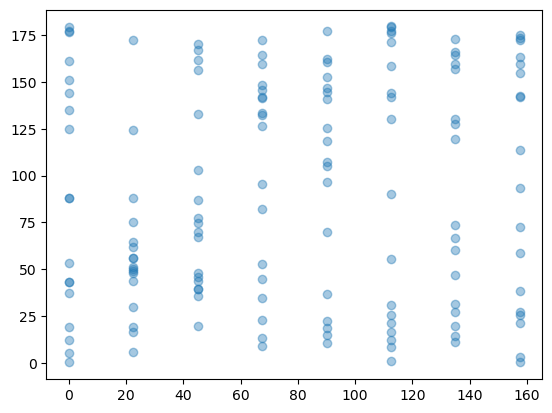

In [439]:
plt.scatter(tmp.groupby('trial_id').ori_true.first(), tmp.groupby('trial_id').ori_pred.first(), alpha=0.4);

# model example

In [ ]:
clf = RandomForestClassifier(n_estimators=100, # max_depth=20, max_features="sqrt",
                            random_state=42,
                            bootstrap=True, oob_score=True, 
                            n_jobs=-1)

clf.fit(X_train_6000, y_train_6000)
y_train_6000_pred = clf.predict(X_train_6000)

from sklearn.metrics import accuracy_score
clf.oob_score_, accuracy_score(y_train_6000, y_train_6000_pred)

(0.7027027027027027, 1.0)

In [ ]:
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)
        
        break
    break

from sklearn.svm import LinearSVR
regr = make_pipeline(StandardScaler(),
                     LinearSVR(epsilon=0, 
                               tol=1e-5, max_iter=int(1e7), 
                               C=0.1, 
                               dual="auto", random_state=0,))

regr.fit(X_train_6000[:, :], y_train_6000[:])
    # print(regr.named_steps['linearsvr'].coef_)
    # print(regr.named_steps['linearsvr'].intercept_)
    # print(sorted(y))
    # print(regr.predict([X_train_6000[-2, :]]))
    # print(regr.predict(X_train_6000) > 0.5)
    # print(y_train_6000[-2])
    # print(y_train_6000)
sum((regr.predict(X_train_6000) > 0.5) == y_train_6000), len(y_train_6000)

# score_val = cross_validate(regr, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

  0%|          | 0/6 [00:01<?, ?it/s]


(34, 36)